### Data 620 - Project 3
### Leticia Salazar
### March 27, 2023

#### Task:

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python (or a classifier from scikit-learn or any other Python ML library), and any features you can think of, build the best name gender classifier you can.

1. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set.
2. Then, starting with the example name gender classifier, make incremental improvements.
3. Use the dev-test set to check your progress.
4. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

#### Import libraries:

Below are the libraries we will be using for this assignment.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.classify import apply_features
import random

### Dataset:

The data we will be using is the `Names Corpus` from the NLTK library. It includes a male.txt and female.txt with list of names pertaining to each respective gender. There's a total of 7944 names among both text files.

In [2]:
# importing the Names corpus from the NLTK corpus
from nltk.corpus import names 

# checking the files in the name corpus
names = nltk.corpus.names
names.fileids()

['female.txt', 'male.txt']

In [3]:
# Printing the number of male names in the text
print("\033[1m" + "\nNumber of male names:" + "\033[0m")
print (len(names.words('male.txt')))

# Printing the number of female names in the text
print("\033[1m" + "\nNumber of female names:" + "\033[0m")
print (len(names.words('female.txt')))


Number of male names:
2943

Number of female names:
5001


Since we know that there are almost twice as many females than male names in this data set it helps to visualie what this looks like.

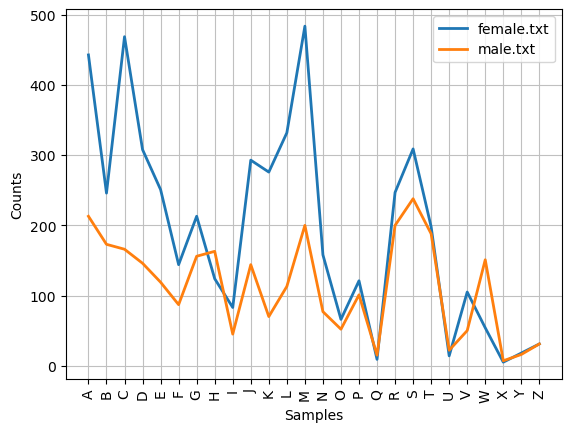

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [4]:
# Check distribution for first letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[0])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()

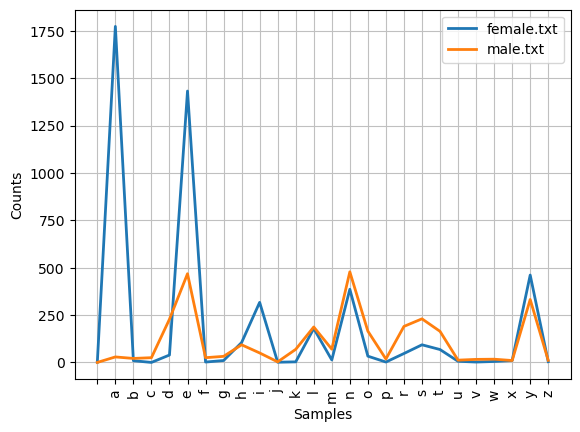

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [5]:
# Check distribution for last letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[-1])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()

### Load Data:

I will be using the code provided by the text book to extract the data.

In [6]:
# Prepare a list of examples and corresponding class labels
names = ([(name, 'male') for name in names.words('male.txt')] +
         [(name, 'female') for name in names.words('female.txt')])
random.seed(7834)
random.shuffle(names)

##### Lets dig into the data to visualize what we are working with:
* First I check the first 15 names of our data
* Then checked for unique names
* View the data for duplicates and remove them so it doesn't skew the data

In [7]:
# displaying the first 15 names with their respective genders
names[0:15]

[('Minni', 'female'),
 ('Vale', 'male'),
 ('Henrie', 'female'),
 ('Willa', 'female'),
 ('Korrie', 'female'),
 ('Eddie', 'male'),
 ('Valerye', 'female'),
 ('Katuscha', 'female'),
 ('Norene', 'female'),
 ('Sutton', 'male'),
 ('Jeannette', 'female'),
 ('Isaiah', 'male'),
 ('Alvin', 'male'),
 ('Shane', 'female'),
 ('Jorie', 'female')]

From the first 30 names we see that male and female names have some distinctive characteristics. Names ending in `a` and `i` are likely to be female, while names ending in `n` and `h` are likely to be male. While `e` seems to be assigned for both male and female Let's build a gender classifier to model these differences more precisely.

In [8]:
# unique names
names_unique = [item[0] for item in names]
print("\033[1m" + "\nNumber of unique names: " + "\033[0m", 
      len(set(names_unique)))


Number of unique names:  7579


In [9]:
# view duplicates
names_dist = nltk.FreqDist(names_unique)
names_dup = [(k,v) for k,v in names_dist.items() if v >1]
names_dup

[('Vale', 2),
 ('Henrie', 2),
 ('Eddie', 2),
 ('Shane', 2),
 ('Pooh', 2),
 ('Harley', 2),
 ('Wynn', 2),
 ('Max', 2),
 ('Cass', 2),
 ('Ikey', 2),
 ('Lindsay', 2),
 ('Shannon', 2),
 ('Lorne', 2),
 ('Eddy', 2),
 ('Terri', 2),
 ('Carey', 2),
 ('Vinny', 2),
 ('Gail', 2),
 ('Bill', 2),
 ('Austin', 2),
 ('Lindy', 2),
 ('Abby', 2),
 ('Elisha', 2),
 ('Alfie', 2),
 ('Leland', 2),
 ('Morgan', 2),
 ('Carroll', 2),
 ('Kerry', 2),
 ('Shawn', 2),
 ('Hilary', 2),
 ('Holly', 2),
 ('Freddy', 2),
 ('Patsy', 2),
 ('Tally', 2),
 ('Bryn', 2),
 ('Angel', 2),
 ('Kelley', 2),
 ('Isa', 2),
 ('Billie', 2),
 ('Willie', 2),
 ('Pattie', 2),
 ('Daffy', 2),
 ('Sasha', 2),
 ('Devin', 2),
 ('Niki', 2),
 ('Shelby', 2),
 ('Georgie', 2),
 ('Brook', 2),
 ('Courtney', 2),
 ('Averil', 2),
 ('Rey', 2),
 ('Andy', 2),
 ('Muffin', 2),
 ('Randie', 2),
 ('Simone', 2),
 ('Lindsey', 2),
 ('Gale', 2),
 ('Nichole', 2),
 ('Leslie', 2),
 ('Deane', 2),
 ('Erin', 2),
 ('Bert', 2),
 ('Cris', 2),
 ('Kyle', 2),
 ('Gus', 2),
 ('Julie', 2),
 (

In [10]:
# lets look at these dups
[item for item in names if item[0] in ["Vinny","Shannon","Page"]]

[('Shannon', 'female'),
 ('Vinny', 'female'),
 ('Vinny', 'male'),
 ('Shannon', 'male'),
 ('Page', 'male'),
 ('Page', 'female')]

Randomly selecting these three names you can see how they are each assigned a female and male gender. In order for this to not affect the testing, I will remove these duplicates.

In [11]:
# Remove the duplicates and show final number of unique names
names_remove = [item[0] for item in names_dup]
names_final = [item for item in names if not item[0] in names_remove]
print("\033[1m" + "Final count of unique names is : "+ "\033[0m", len(names_final))

Final count of unique names is :  7214


### Splitting the Names Corpus:

Now we are ready to start splitting; I will use the code from the textbook to create a gender classifier with the last letter of the name and use the feature extractor to process the names data. Finally, use the training set data to create a new naive Bayes classifier.

In [12]:
# Test set 500 words
test_split = names_final[:500]

# Dev-Test set 500 words
devtest_split = names_final[500:1000]

# Training set remaining words 6214
train_split = names_final[1000:]

### First Feature: first letter of the name 

In [13]:
# Create first gender classifier
def gender_features(name):
    return {'first_letter': name[0]}

In [14]:
# Performance devtest
train_set = [(gender_features(n), g) for (n,g) in train_split]
devtest_set = [(gender_features(n), g) for (n,g) in devtest_split]
classifier = nltk.NaiveBayesClassifier.train(train_set)

devtest_accuracy = nltk.classify.accuracy(classifier, devtest_set)
print("\033[1m" + "The accuracy for the devtest_set using Feature 1 is: " + "\033[0m" + str(devtest_accuracy))

# Performance test 
test_set = [(gender_features(n), g) for (n,g) in test_split]
test_set2 = nltk.classify.accuracy(classifier, test_set)
print("\033[1m" + "The accuracy for the test_set using Feature 1 is: " + "\033[0m" + str(test_set2))

The accuracy for the devtest_set using Feature 1 is: 0.636
The accuracy for the test_set using Feature 1 is: 0.67


Now examine the first classifier to show the first 5 features found most effective in the gender names.

These results show that the first letters `W`, `Q`, `U`, and `X` are predominately male names where as `K` are predominately female names.

In [15]:
# examine classifier
classifier.show_most_informative_features(5)

Most Informative Features
            first_letter = 'W'              male : female =      5.9 : 1.0
            first_letter = 'Q'              male : female =      4.4 : 1.0
            first_letter = 'U'              male : female =      3.7 : 1.0
            first_letter = 'X'              male : female =      2.6 : 1.0
            first_letter = 'K'            female : male   =      2.4 : 1.0


In [16]:
#Function to generate errors
def generate_errors(gender_features): 
    
    errors = [] 

    for (name, tag) in devtest_split:
        guess = classifier.classify(gender_features(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

#Function to print error
def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))
        
        
    print("\033[1m" + 'The number of errors for the first feature is : '+ "\033[0m" , len(errors))
    
# Show error in devtest
show_errors(generate_errors(gender_features))

correct=female   guess=male     name=Hally                         
correct=female   guess=male     name=Hynda                         
correct=female   guess=male     name=Quinta                        
correct=female   guess=male     name=Quintina                      
correct=female   guess=male     name=Ulla                          
correct=female   guess=male     name=Ursala                        
correct=female   guess=male     name=Ursuline                      
correct=female   guess=male     name=Willow                        
correct=female   guess=male     name=Wilmette                      
correct=female   guess=male     name=Winna                         
correct=female   guess=male     name=Xylina                        
correct=female   guess=male     name=Yevette                       
correct=female   guess=male     name=Yolanthe                      
correct=female   guess=male     name=Yvette                        
correct=female   guess=male     name=Zabrina    

### Second Feature: last letter of the name 

In [17]:
# Create 2nd gender classifier with just the last letter of the name
def gender_features2(name):
    return {'last_letter': name[-1]}

In [18]:
# Performance devtest
train_set2 = [(gender_features2(n), g) for (n,g) in train_split]
devtest_set2 = [(gender_features2(n), g) for (n,g) in devtest_split]
classifier2 = nltk.NaiveBayesClassifier.train(train_set2)

devtest_accuracy2 = nltk.classify.accuracy(classifier2, devtest_set2)
print("\033[1m" + "The accuracy for the devtest_set using Feature 2 is: "+ "\033[0m" + str(devtest_accuracy2))

# Performance test 
test_set = [(gender_features2(n), g) for (n,g) in test_split]
test_set2 = nltk.classify.accuracy(classifier2, test_set)
print("\033[1m" + "The accuracy for the test_set using Feature 2 is: " + "\033[0m" + str(test_set2))

The accuracy for the devtest_set using Feature 2 is: 0.786
The accuracy for the test_set using Feature 2 is: 0.806


Now examine the second classifier to show the first 5 features found most effective in the gender names.

These results show that the last letters `k`, `p`, `f`, and `m` are predominately male names where as `a` are predominately female names.

In [19]:
# examine classifier
classifier2.show_most_informative_features(5)

Most Informative Features
             last_letter = 'k'              male : female =     70.2 : 1.0
             last_letter = 'a'            female : male   =     67.7 : 1.0
             last_letter = 'p'              male : female =     19.8 : 1.0
             last_letter = 'f'              male : female =     16.9 : 1.0
             last_letter = 'm'              male : female =     13.8 : 1.0


In [20]:
#Function to generate errors
def generate_errors2(gender_features2): 
    
    errors = [] 

    for (name, tag) in devtest_split:
        guess = classifier.classify(gender_features2(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

#Function to print error
def show_errors2(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))
        
        
    print("\033[1m" + 'The number of errors for the second feature is : '+ "\033[0m" , len(errors))
    
# Show error in devtest
show_errors(generate_errors2(gender_features2))

correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Alic                          
correct=male     guess=female   name=Alonso                        
correct=male     guess=female   name=Andros                        
correct=male     guess=female   name=Anson                         
correct=male     guess=female   name=Anthony                       
correct=male     guess=female   name=Antoni                        
correct=male     guess=female   name=Antonio                       
correct=male     guess=female   name=Arvind                        
correct=male     guess=female   name=Augustus                      
correct=male     guess=female   name=Avery                         
correct=male     guess=female   name=Avraham                       
correct=male     guess=female   name=Barney                        
correct=male     guess=female   name=Bela                          
correct=male     guess=female   name=Berkley    

### Third Feature: example from textbook

In [21]:
# Create 3rd gender classifier as seen on textbook
def gender_features3(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features

In [22]:
# Performance devtest
train_set3 = [(gender_features3(n), g) for (n,g) in train_split]
devtest_set3 = [(gender_features3(n), g) for (n,g) in devtest_split]
classifier3 = nltk.NaiveBayesClassifier.train(train_set3)

devtest_accuracy3 = nltk.classify.accuracy(classifier3, devtest_set3)
print("\033[1m" + "The accuracy for the devtest_set using Feature 3 is: " + "\033[0m" + str(devtest_accuracy3))

# Performance test 
test_set = [(gender_features3(n), g) for (n,g) in test_split]
test_set2 = nltk.classify.accuracy(classifier3, test_set)
print("\033[1m" + "The accuracy for the test_set using Feature 3 is: " + "\033[0m" + str(test_set2))

The accuracy for the devtest_set using Feature 3 is: 0.816
The accuracy for the test_set using Feature 3 is: 0.806


Now examine the third classifier to show the first 5 features found most effective in the gender names.

This results show the same results in classifier 3.

In [23]:
classifier3.show_most_informative_features(5)

Most Informative Features
              lastletter = 'k'              male : female =     70.2 : 1.0
              lastletter = 'a'            female : male   =     67.7 : 1.0
              lastletter = 'p'              male : female =     19.8 : 1.0
              lastletter = 'f'              male : female =     16.9 : 1.0
              lastletter = 'm'              male : female =     13.8 : 1.0


In [24]:
#Function to generate errors
def generate_errors3(gender_features3): 
    
    errors = [] 

    for (name, tag) in devtest_split:
        guess = classifier.classify(gender_features3(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

#Function to print error
def show_errors3(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))
        
        
    print("\033[1m" + 'The number of errors for the third feature is  : '+ "\033[0m" , len(errors))
    
# Show error in devtest
show_errors(generate_errors3(gender_features3))

correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Alic                          
correct=male     guess=female   name=Alonso                        
correct=male     guess=female   name=Andros                        
correct=male     guess=female   name=Anson                         
correct=male     guess=female   name=Anthony                       
correct=male     guess=female   name=Antoni                        
correct=male     guess=female   name=Antonio                       
correct=male     guess=female   name=Arvind                        
correct=male     guess=female   name=Augustus                      
correct=male     guess=female   name=Avery                         
correct=male     guess=female   name=Avraham                       
correct=male     guess=female   name=Barney                        
correct=male     guess=female   name=Bela                          
correct=male     guess=female   name=Berkley    

### Fourth Feature: use first and last letter and two suffixes as features

In [25]:
# Create a 4th gender classifier with 2 extractors that used first & last
# letter and two suffixes as features
def gender_features4(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    features["suffix2"] = name[-2:].lower()
    features["suffix3"] = name[-3:].lower()
    return features

In [26]:
# Performance devtest
train_set4 = [(gender_features4(n), g) for (n,g) in train_split]
devtest_set4 = [(gender_features4(n), g) for (n,g) in devtest_split]
classifier4 = nltk.NaiveBayesClassifier.train(train_set4)

devtest_accuracy4 = nltk.classify.accuracy(classifier4, devtest_set4)
print("\033[1m" + "The accuracy for the devtest_set using Feature 4 is: "+ "\033[0m" + str(devtest_accuracy4))

# Performance test 
test_set = [(gender_features4(n), g) for (n,g) in test_split]
test_set2 = nltk.classify.accuracy(classifier4, test_set)
print("\033[1m" + "The accuracy for the test_set using Feature 4 is: " + "\033[0m" + str(test_set2))

The accuracy for the devtest_set using Feature 4 is: 0.852
The accuracy for the test_set using Feature 4 is: 0.86


Now examine the fourth classifier to show the first 5 features found most effective in the gender names.

These results show that the last letters `k` and suffix `rt` are predominately male names where as last letter `a` and suffiexes `ia` and `ra` are predominately female names.

In [27]:
classifier4.show_most_informative_features(5)

Most Informative Features
                 suffix2 = 'ia'           female : male   =     82.1 : 1.0
              lastletter = 'k'              male : female =     70.2 : 1.0
              lastletter = 'a'            female : male   =     67.7 : 1.0
                 suffix2 = 'ra'           female : male   =     53.3 : 1.0
                 suffix2 = 'rt'             male : female =     48.7 : 1.0


In [28]:
#Function to generate errors
def generate_errors4(gender_features4): 
    
    errors = [] 

    for (name, tag) in devtest_split:
        guess = classifier.classify(gender_features4(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

#Function to print error
def show_errors4(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))
        
        
    print("\033[1m" + 'The number of errors for the fourth feature is : '+ "\033[0m" , len(errors))
    
# Show error in devtest
show_errors(generate_errors4(gender_features4))

correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Alic                          
correct=male     guess=female   name=Alonso                        
correct=male     guess=female   name=Andros                        
correct=male     guess=female   name=Anson                         
correct=male     guess=female   name=Anthony                       
correct=male     guess=female   name=Antoni                        
correct=male     guess=female   name=Antonio                       
correct=male     guess=female   name=Arvind                        
correct=male     guess=female   name=Augustus                      
correct=male     guess=female   name=Avery                         
correct=male     guess=female   name=Avraham                       
correct=male     guess=female   name=Barney                        
correct=male     guess=female   name=Bela                          
correct=male     guess=female   name=Berkley    

Checking if the classifiers can identify names other than the ones included in the text as `male` or `female` correctly based on the features assigned. Oddly enough all the outputs for these classifiers was female.

In [29]:
# male and female classifier name for feature 1
gen_ft1 = classifier.classify(gender_features('Neo'))
print('Classifier 1 male name: ', gen_ft1)
fem_genft1 = classifier.classify(gender_features('Mary'))
print('Classifier 1 female name: ', fem_genft1)

# male and female classifier name for feature 2
gen_ft2 = classifier.classify(gender_features2('Neo'))
print('Classifier 2 male name: ', gen_ft2)
fem_genft2 = classifier.classify(gender_features2('Mary'))
print('Classifier 2 female name: ', fem_genft2)

# male and female classifier name for feature 3
gen_ft3 = classifier.classify(gender_features3('Neo'))
print('Classifier 3 male name: ', gen_ft3)
fem_genft3 = classifier.classify(gender_features3('Mary'))
print('Classifier 3 female name: ', fem_genft3)

# male and female classifier name for feature 4
gen_ft4 = classifier.classify(gender_features4('Neo'))
print('Classifier 4 male name: ', gen_ft4)
fem_genft4 = classifier.classify(gender_features4('Mary'))
print('Classifier 4 female name: ', fem_genft4)

Classifier 1 male name:  female
Classifier 1 female name:  female
Classifier 2 male name:  female
Classifier 2 female name:  female
Classifier 3 male name:  female
Classifier 3 female name:  female
Classifier 4 male name:  female
Classifier 4 female name:  female


### Conclusion:

##### How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

After comparing all four gender features, classifier 4 did better compared to the first three with the results being as follows:

* The accuracy for the devtest_set using Feature 4 is: 0.852
* The accuracy for the test_set using Feature 4 is: 0.86

Overall, classifiers 1, 2 and 4 had dev-test sets with lower percentage than the test set. Classifier 3 dev-test set had a higher percentage than the test set.

### References:
* Bird, S., Klein, E., &amp; Loper, E. (2009). Learning to Classify Text. In Natural language processing with python (pp. 221â€“259). essay, O'Reilly. 